In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from poola import core as pool
import gpplot

In [2]:
path = '../Data/ExternalData/Gilbert 2014/'
seq_detail = pd.read_table(path+"CRISPRicin library 20130912_final_draft_CRISPRicin.txt", header = None)
seq_count = pd.read_table(path + '20230811_counts_files_combined.txt')
seq_count = seq_count[['0', 'dCas9-KRAB ricin LG',  
       'dCas9-KRAB ricin MH', 'dCas9-KRAB untreated MH',
       'dCas9-KRAB untreated LG']]
seq_phenotpye = pd.read_excel(path + 'CRISPRricin compiled all sgRNA data.xlsx', header = None)
new_col_seq_phenotpye = ['guide id'] + seq_phenotpye[[1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,17, 18, 19, 20, 21, 22, 23, 24]][0:3].apply('_'.join,  axis=0).tolist()
seq_phenotpye = seq_phenotpye.drop([0, 1,2,3], axis=0)
seq_phenotpye.columns = new_col_seq_phenotpye
seq_phenotpye
seq_count

/Users/fzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,0,dCas9-KRAB ricin LG,dCas9-KRAB ricin MH,dCas9-KRAB untreated MH,dCas9-KRAB untreated LG
0,ARCN1_c_118438373.25,30.0,24.0,50.0,90.0
1,ARCN1_c_118438478.24,951.0,805.0,650.0,955.0
2,ARCN1_c_118438478.26,796.0,486.0,399.0,430.0
3,ARCN1_c_118438508.26,1021.0,527.0,555.0,825.0
4,ARCN1_c_118438682.27,642.0,865.0,656.0,835.0
...,...,...,...,...,...
55495,negYIPF5_c_143553099.25,397.0,152.0,192.0,272.0
55496,negYIPF5_c_143553316.27,366.0,133.0,404.0,544.0
55497,negYIPF5_w_143550317.26,771.0,539.0,449.0,603.0
55498,negYIPF5_w_143553763.25,1022.0,1441.0,853.0,1058.0


In [3]:
# use count to calcuate LFC: remove T0 with z-score less than -3
lognorms_tiling = pool.lognorm_columns(reads_df=seq_count, columns=['dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH', 
                                                                          'dCas9-KRAB untreated MH','dCas9-KRAB untreated LG'])
filtered_lognorms_tiling = pool.filter_pdna(lognorm_df=lognorms_tiling, 
                                                  pdna_cols=['dCas9-KRAB untreated MH','dCas9-KRAB untreated LG'], z_low=-3)
print('Filtered ' + str(lognorms_tiling.shape[0] - filtered_lognorms_tiling.shape[0]) + ' rows due to low pDNA abundance')


Filtered 1092 rows due to low pDNA abundance


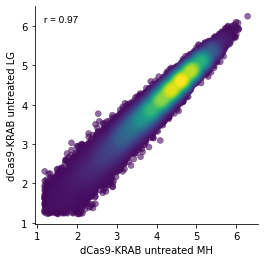

In [4]:
# use count to calcuate LFC: check lognorms of T0 repeats correlation 
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=filtered_lognorms_tiling, x='dCas9-KRAB untreated MH', y='dCas9-KRAB untreated LG')
gpplot.add_correlation(data=filtered_lognorms_tiling, x='dCas9-KRAB untreated MH', y='dCas9-KRAB untreated LG')
sns.despine()

In [5]:
# use count to calcuate LFC: find average lognorms of T0 because they corrlate well
filtered_lognorms_tiling['avgCountsUntreated'] = filtered_lognorms_tiling[['dCas9-KRAB untreated MH', 'dCas9-KRAB untreated LG']].mean(axis=1)



In [6]:
# use count to calcuate LFC: calcuate LFC relative to the averaged T0 lognmorm 
lfc_tiling = pool.calculate_lfcs(lognorm_df=filtered_lognorms_tiling, 
                                         ref_col='avgCountsUntreated', 
                                       target_cols=['dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH'])
lfc_tiling = lfc_tiling[['0', 'dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH']]
lfc_tiling.head()


,0,dCas9-KRAB ricin LG,dCas9-KRAB ricin MH
0,ARCN1_c_118438373.25,-0.914327,-0.945535
1,ARCN1_c_118438478.24,-0.200292,-0.195294
2,ARCN1_c_118438478.26,0.434630,-0.004084
3,ARCN1_c_118438508.26,0.108739,-0.563859
4,ARCN1_c_118438682.27,-0.651167,-0.009016


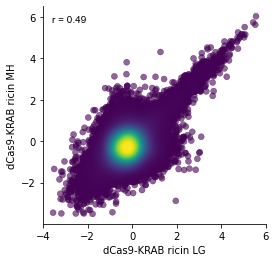

In [7]:
#remove nas
lfc_tiling = lfc_tiling.dropna()
#  check LFC of Tfinal repeats correlation 
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_tiling, x='dCas9-KRAB ricin LG', y='dCas9-KRAB ricin MH')
gpplot.add_correlation(data=lfc_tiling, x='dCas9-KRAB ricin LG', y='dCas9-KRAB ricin MH')
sns.despine()

In [8]:
# find average LFC of Tfinal because they corrlate moderately
lfc_tiling['Avg_LFC'] = lfc_tiling[['dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH']].mean(axis=1)


In [9]:
# add orginal phenotyp (activity score was called rho by gilbert et al)
lfc_tiling = pd.merge(seq_phenotpye[['guide id','dCas9-KRAB_rho_ave_LG2_LG_MH2_MH']],
         lfc_tiling.rename(columns = {'0': 'guide id'}))
lfc_tiling["dCas9-KRAB_rho_ave_LG2_LG_MH2_MH"] = lfc_tiling["dCas9-KRAB_rho_ave_LG2_LG_MH2_MH"].astype(float)
len(lfc_tiling)

54403

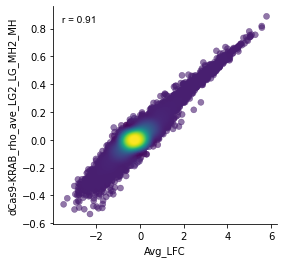

In [10]:
#  check LFC vs rho  correlation 
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_tiling, x='Avg_LFC', y='dCas9-KRAB_rho_ave_LG2_LG_MH2_MH')
gpplot.add_correlation(data=lfc_tiling, x='Avg_LFC', y='dCas9-KRAB_rho_ave_LG2_LG_MH2_MH' )
sns.despine()

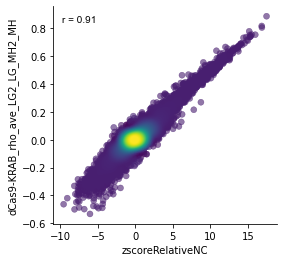

In [11]:
# calcuate z-score relative to neg control
nc_mean = lfc_tiling[lfc_tiling['guide id'].str[:3] == "neg"]['Avg_LFC'].mean()
nc_mean_std = lfc_tiling[lfc_tiling['guide id'].str[:3] == "neg"]['Avg_LFC'].std()
lfc_tiling['zscoreRelativeNC'] = (lfc_tiling['Avg_LFC'] - nc_mean)/nc_mean_std

#  check orginal phenotype vs zscore for all 54403 guide
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_tiling, x='zscoreRelativeNC', y='dCas9-KRAB_rho_ave_LG2_LG_MH2_MH')
gpplot.add_correlation(data=lfc_tiling, x='zscoreRelativeNC', y='dCas9-KRAB_rho_ave_LG2_LG_MH2_MH' )
sns.despine()

In [12]:
dcas_krab = pd.merge(lfc_tiling,seq_detail.rename(columns = {0: 'guide id', 1: 'oligo'}), 
                     on = 'guide id' ).dropna()

In [13]:
dcas_krab[['Gene', 'Position']] = dcas_krab['guide id'].str.split(pat = '_', n = 1, expand=True)
#dcas_krab.to_csv('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/2023/k562_tiling/CRISPRi/dcas_krab.csv', index = False)
dcas_krab.head()

,guide id,dCas9-KRAB_rho_ave_LG2_LG_MH2_MH,dCas9-KRAB ricin LG,dCas9-KRAB ricin MH,Avg_LFC,zscoreRelativeNC,oligo,Gene,Position
0,ARCN1_c_118438373.25,-0.120761,-0.914327,-0.945535,-0.929931,-2.063088,cccttggagaaCCAcctTGTTGGAAAACCTACCAGAGGTAAACAGT...,ARCN1,c_118438373.25
1,ARCN1_c_118438478.24,0.012341,-0.200292,-0.195294,-0.197793,0.067421,cccttggagaaCCAcctTGTTGGATCTGTTTTGCTCGtaatagGTT...,ARCN1,c_118438478.24
2,ARCN1_c_118438478.26,0.029811,0.434630,-0.004084,0.215273,1.269436,cccttggagaaCCAcctTGTTGGTGATCTGTTTTGCTCGtaatagG...,ARCN1,c_118438478.26
3,ARCN1_c_118438508.26,0.022175,0.108739,-0.563859,-0.227560,-0.019199,cccttggagaaCCAcctTGTTGgtaatgtgcagtacttactatgtG...,ARCN1,c_118438508.26
4,ARCN1_c_118438682.27,-0.031622,-0.651167,-0.009016,-0.330092,-0.317565,cccttggagaaCCAcctTGTTGgcgctgaaaatagcagccaaacac...,ARCN1,c_118438682.27


- RPS25 and C4orf41 only in CRISPRi
- TRAPPC11 only in CRISPRko
- 50 genes in CRISPRi instead of 49

In [14]:
# Drop negative controls and mismatches 
tiling_crispri = dcas_krab[dcas_krab['guide id'].str[:3] != "neg"]
tiling_crispri = tiling_crispri[tiling_crispri['guide id'].str[:3] != "mis"]
print(len(tiling_crispri))

52541


In [15]:
tiling_crispri["gene symbol"] = tiling_crispri['guide id'].str.split("_").str[0]
tiling_crispri["temp"] = tiling_crispri['guide id'].str.split("_").str[2]
tiling_crispri["pam coordinate (hg19)"] = tiling_crispri.temp.str.split(".").str[0]
tiling_crispri["length (including pam)"] = tiling_crispri.temp.str.split(".").str[1]
tiling_crispri.drop('temp', axis=1, inplace=True)


In [16]:
tiling_crispri.drop('Position', axis=1, inplace=True)
tiling_crispri.drop('Gene', axis=1, inplace=True)

In [17]:
tiling_crispri["pam coordinate (hg19)"] = tiling_crispri["pam coordinate (hg19)"].astype(np.int64)
tiling_crispri["length (including pam)"] = tiling_crispri["length (including pam)"].astype(np.int64)

# The PAM site from the KO data seems to be off by 1 from the CRISPRi data (described in details in the basecamp post)
tiling_crispri["pam coordinate (hg19) - 1"] = tiling_crispri["pam coordinate (hg19)"] - 1
tiling_crispri


,guide id,dCas9-KRAB_rho_ave_LG2_LG_MH2_MH,dCas9-KRAB ricin LG,dCas9-KRAB ricin MH,Avg_LFC,zscoreRelativeNC,oligo,gene symbol,pam coordinate (hg19),length (including pam),pam coordinate (hg19) - 1
0,ARCN1_c_118438373.25,-0.120761,-0.914327,-0.945535,-0.929931,-2.063088,cccttggagaaCCAcctTGTTGGAAAACCTACCAGAGGTAAACAGT...,ARCN1,118438373,25,118438372
1,ARCN1_c_118438478.24,0.012341,-0.200292,-0.195294,-0.197793,0.067421,cccttggagaaCCAcctTGTTGGATCTGTTTTGCTCGtaatagGTT...,ARCN1,118438478,24,118438477
2,ARCN1_c_118438478.26,0.029811,0.434630,-0.004084,0.215273,1.269436,cccttggagaaCCAcctTGTTGGTGATCTGTTTTGCTCGtaatagG...,ARCN1,118438478,26,118438477
3,ARCN1_c_118438508.26,0.022175,0.108739,-0.563859,-0.227560,-0.019199,cccttggagaaCCAcctTGTTGgtaatgtgcagtacttactatgtG...,ARCN1,118438508,26,118438507
4,ARCN1_c_118438682.27,-0.031622,-0.651167,-0.009016,-0.330092,-0.317565,cccttggagaaCCAcctTGTTGgcgctgaaaatagcagccaaacac...,ARCN1,118438682,27,118438681
...,...,...,...,...,...,...,...,...,...,...,...
52536,YIPF5_w_143554761.28,-0.001537,-0.815790,0.322879,-0.246456,-0.074186,cccttggagaaCCAcctTGTTGgggcattacatggcacctacctca...,YIPF5,143554761,28,143554760
52537,YIPF5_w_143554879.28,0.024536,0.387752,0.217012,0.302382,1.522921,cccttggagaaCCAcctTGTTGgcctactgctttagcataaggact...,YIPF5,143554879,28,143554878
52538,YIPF5_w_143554997.27,-0.050816,-0.726116,-1.365320,-1.045718,-2.400026,cccttggagaaCCAcctTGTTGgtctagttgcaattttaatttata...,YIPF5,143554997,27,143554996
52539,YIPF5_w_143555197.28,-0.062784,-0.942657,-0.485616,-0.714136,-1.435129,cccttggagaaCCAcctTGTTGgtacagaatgtaaatccatgcagt...,YIPF5,143555197,28,143555196


In [18]:
# check if theres any duplicates on the columns we are going to merge on 
tiling_crispri[['gene symbol', 'length (including pam)', 'pam coordinate (hg19) - 1']].duplicated().any()

False

In [19]:
path = '../Data/ExternalData/CRISPRko Horlbeck/'
new_tiling = pd.read_csv(path+'cleaned_horlbeck_tiling.csv') # cleaned ko

new_tiling[['gene symbol', 'sgRNA length (including PAM)','PAM genomic coordinate [hg19]']].duplicated().any()

False

In [20]:
merged_tiling = pd.merge(tiling_crispri, new_tiling, 
         left_on = ['gene symbol', 'length (including pam)', 'pam coordinate (hg19) - 1'],
         right_on = ['gene symbol', 'sgRNA length (including PAM)','PAM genomic coordinate [hg19]'])

In [21]:
# check unique oligo; all oligos are unique
merged_tiling['oligo'].value_counts()

cccttggagaaCCAcctTGTTGGAAAACCTACCAGAGGTAAACAGTTTAAGAGCTATGCTGGAAACAGCATAGCAAGTTTAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTTTagtcCtcgagcgtcgaggatccattagg    1
cccttggagaaCCAcctTGTTGgtggcaTAATGAAATTTTTCATcaGTTTAAGAGCTATGCTGGAAACAGCATAGCAAGTTTAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTTTagCtcgagcgtcgaggatccattagg    1
cccttggagaaCCAcctTGTTGgggactgttctgtatattgtgtGTTTAAGAGCTATGCTGGAAACAGCATAGCAAGTTTAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTTTagtcCtcgagcgtcgaggatccattagg    1
cccttggagaaCCAcctTGTTGggggactgttctgtatattgtgtGTTTAAGAGCTATGCTGGAAACAGCATAGCAAGTTTAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTTTagtCtcgagcgtcgaggatccattagg    1
cccttggagaaCCAcctTGTTGgactgttctgtatattgtgtaggGTTTAAGAGCTATGCTGGAAACAGCATAGCAAGTTTAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTTTagtCtcgagcgtcgaggatccattagg    1
                                                                                                                                                 

In [22]:
# check unique sgRNA sequence; all sgRNA sequence are unique
merged_tiling['sgRNA sequence'].value_counts()

GAAAACCTACCAGAGGTAAACA       1
gtggcaTAATGAAATTTTTCATca     1
gggactgttctgtatattgtgt       1
ggggactgttctgtatattgtgt      1
gactgttctgtatattgtgtagg      1
                            ..
GCCCAGCCCGCCGAGAGGCTC        1
GCGCCCAGCCCGCCGAGAGGCTC      1
GCCCGCCGAGAGGCTCAGGCCCC      1
GCCGAGAGGCTCAGGCCCCGGG       1
gtttaaataaattactgaagctcca    1
Name: sgRNA sequence, Length: 51101, dtype: int64

In [23]:
# number of overlap between merged ko and crispri
# looks like all the rows have ko and crispri overlapped yayy!!

sum(merged_tiling.apply(lambda row: row['sgRNA sequence'] in row['oligo'],
                     axis=1))

51101

In [24]:
merged_tiling[['gene symbol', 'chromosome', 'strand targeted','PAM genomic coordinate [hg38]']].nunique()

gene symbol                         48
chromosome                          16
strand targeted                      2
PAM genomic coordinate [hg38]    29243
dtype: int64

In [25]:
#import dany's annotation of context seq for CRSIPRko
#2023/CRISPRiAnalysis /Dany/Horlbeck KO Ricin Tiling
# Horlbeck-KO.ipynb to get the coordinates 
# RS3 Scores for Horlbeck tiling guides.ipynb use the coordinate file from Horlbeck-KO.ipynb as input to get context seq
dany_context_seq = pd.read_csv('../Data/ExternalData/CRISPRko Horlbeck/Dany-horlbeck-tiling-with-rs3.csv')
dany_context_seq.head()

,gene symbol,chromosome,strand targeted,hg38_coord,context seq,Position relative to FANTOM5 TSS,absolute z-score,rs3 score
0,ARCN1,chr11,+,118567638.0,GCACTTTCCTTGTTTACCTCTGGTAGGTTT,-4793.0,0.409907,-0.067121
1,ARCN1,chr11,+,118567850.0,ATTGGCAGTAACATCTATCTCATAAGGTTG,-4581.0,0.694579,-0.554137
2,ARCN1,chr11,+,118567997.0,TCCCATAGTGGCAGTATCTTATAATGGTTA,-4434.0,0.566546,-0.090399
3,ARCN1,chr11,+,118568013.0,CATGCTTCTTGAGGAGTCCCATAGTGGCAG,-4418.0,0.997859,0.220064
4,ARCN1,chr11,+,118568026.0,GCAACCCTGTAAGCATGCTTCTTGAGGAGT,-4405.0,0.386895,-0.563347


in the current cleaned Gilbert Rising datasets there are guides with 25 nts and its not completely in the context sequence because 25+6 = 31 and larger than 30 nts context sequence length. Gilbert length is gene_c/w_coord.(length + 3). So need to remember to reive guide id ends with 28

In [26]:
merged_tiling['length'] = merged_tiling['guide id'].str[-2:]
merged_tiling = merged_tiling[merged_tiling['length'] != '28']

In [27]:
# check if the dataframe im merging has duplicates
merged_tiling[['gene symbol', 'chromosome', 'strand targeted','PAM genomic coordinate [hg38]']].duplicated().any()

True

In [28]:
# check if the dataframe im merging has duplicates
dany_context_seq.rename(columns={'hg38_coord':'PAM genomic coordinate [hg38]'})[['gene symbol', 'chromosome', 'strand targeted','PAM genomic coordinate [hg38]']].duplicated().any()


False

In [29]:
merged_tiling_w_context = pd.merge(
         dany_context_seq[['gene symbol', 'chromosome', 'strand targeted', 'hg38_coord',
       'context seq']].rename(columns={'hg38_coord':'PAM genomic coordinate [hg38]'}),
    merged_tiling[['guide id', 'oligo', 'gene symbol', 'chromosome',
       'strand targeted', 'sgRNA sequence','PAM genomic coordinate [hg38]',
        'dCas9-KRAB_rho_ave_LG2_LG_MH2_MH', 'zscoreRelativeNC','Avg_LFC']],
         on = ['gene symbol', 'chromosome', 'strand targeted','PAM genomic coordinate [hg38]'],
                     how = 'inner')

In [30]:
merged_tiling_w_context['sgRNA sequence'].value_counts()

GCACTTTCCTTGTTTACCTCTGGT    1
gagttgtaaaatagcatactcaa     1
GATTCAAATATTCAGCAACCTGCT    1
GATTCAAATATTCAGCAACCTGC     1
gctcagccTAAATTCTGTATTTCT    1
                           ..
GCCCCTCAGCCCGCCGGACTC       1
GAGCTTCGCCTCTGTAGCTC        1
GTCTGAGCTTCGCCTCTGTAGCTC    1
GCCTCTGTAGCTCCGGTTTAG       1
gagtccttatgctaaagcagt       1
Name: sgRNA sequence, Length: 39009, dtype: int64

In [31]:
merged_tiling_w_context['context seq'].value_counts()

GGGGTGTGCCTGCAAATGTCCGCGTGGTTC    5
GGGGAGGGTGGCGCGGGTAGAAACCGGCTT    5
GGGGCGGAACAGAACTGGGCGCGCGGGGGC    5
GAGGGGTGACCTTTAACCTTTGGAAGGGCA    5
GGGGGCGATGGAATCCGGGAGCGGTGGAAC    5
                                 ..
GAACCTCTATACATGCAACGACTTGGGGAG    1
ACAGACAACTCATCTCTTACCCACAGGTAA    1
TAAGAAACTGAGTATCATCTCCTTTGGCCC    1
AGTATCATCTCCTTTGGCCCGGTGTGGTGG    1
CCTGAGTCCTTATGCTAAAGCAGTAGGCTG    1
Name: context seq, Length: 24797, dtype: int64

In [32]:
# check out duplicated context seq
dupliated_df_same_gene = merged_tiling_w_context[merged_tiling_w_context[['context seq','gene symbol']].duplicated(keep = False)]
dupliated_df_same_gene[dupliated_df_same_gene['context seq'] == 'CCGGAGCCTGCTTGTTGCAGCTGTGGGTGA']

,gene symbol,chromosome,strand targeted,PAM genomic coordinate [hg38],context seq,guide id,oligo,sgRNA sequence,dCas9-KRAB_rho_ave_LG2_LG_MH2_MH,zscoreRelativeNC,Avg_LFC
26401,SEC23B,chr20,-,18507952.0,CCGGAGCCTGCTTGTTGCAGCTGTGGGTGA,SEC23B_c_18488597.24,cccttggagaaCCAcctTGTTGGAGCCTGCTTGTTGCAGCTGTGTT...,GAGCCTGCTTGTTGCAGCTGT,0.806408,16.880138,5.579808
26402,SEC23B,chr20,-,18507952.0,CCGGAGCCTGCTTGTTGCAGCTGTGGGTGA,SEC23B_c_18488597.25,cccttggagaaCCAcctTGTTGGGAGCCTGCTTGTTGCAGCTGTGT...,GGAGCCTGCTTGTTGCAGCTGT,0.817704,16.855899,5.571478


In [33]:
len(merged_tiling_w_context[merged_tiling_w_context[['context seq']].duplicated(keep = False)]) == len(dupliated_df_same_gene)
# all the duplicated seq are within gene

True

In [34]:
# if the duplicated context seq are within the same gene then i take the average rho
for seq in dupliated_df_same_gene['context seq'].unique():
    seq_df = merged_tiling_w_context[merged_tiling_w_context['context seq'] == seq]
    if len(set(seq_df['gene symbol'])) == 1:
        merged_tiling_w_context.loc[seq_df.index,'dCas9-KRAB_rho_ave_LG2_LG_MH2_MH'] = seq_df['dCas9-KRAB_rho_ave_LG2_LG_MH2_MH'].mean()
        merged_tiling_w_context.loc[seq_df.index,'zscoreRelativeNC'] = seq_df['zscoreRelativeNC'].mean()
        merged_tiling_w_context.loc[seq_df.index,'Avg_LFC'] = seq_df['Avg_LFC'].mean()



In [35]:
cleaned_df = merged_tiling_w_context.drop_duplicates(['gene symbol','context seq','dCas9-KRAB_rho_ave_LG2_LG_MH2_MH'], keep = 'first').copy()

In [36]:
# no duplicates
cleaned_df[cleaned_df.duplicated()]

,gene symbol,chromosome,strand targeted,PAM genomic coordinate [hg38],context seq,guide id,oligo,sgRNA sequence,dCas9-KRAB_rho_ave_LG2_LG_MH2_MH,zscoreRelativeNC,Avg_LFC


In [37]:
cleaned_df['context seq'].nunique() == len(cleaned_df)

True

In [38]:
sum(cleaned_df['context seq'].str[25:27] != 'GG')

0

In [39]:
cleaned_df['sgRNA sequence in Context'] = cleaned_df.apply(lambda row: row['sgRNA sequence'].upper() in row['context seq'].upper(),
                     axis=1)
# only kept rows with sgRNA in Context
cleaned_df = cleaned_df[cleaned_df['sgRNA sequence in Context'] == True]

In [40]:
cleaned_df[cleaned_df['context seq'] == 'CCGGAGCCTGCTTGTTGCAGCTGTGGGTGA']

,gene symbol,chromosome,strand targeted,PAM genomic coordinate [hg38],context seq,guide id,oligo,sgRNA sequence,dCas9-KRAB_rho_ave_LG2_LG_MH2_MH,zscoreRelativeNC,Avg_LFC,sgRNA sequence in Context
26401,SEC23B,chr20,-,18507952.0,CCGGAGCCTGCTTGTTGCAGCTGTGGGTGA,SEC23B_c_18488597.24,cccttggagaaCCAcctTGTTGGAGCCTGCTTGTTGCAGCTGTGTT...,GAGCCTGCTTGTTGCAGCTGT,0.812056,16.868019,5.575643,True


In [41]:
len(cleaned_df)

24791

To figure out which guides are expected to offer resistance vs susceptibility to ricin, I am looking to the referenced Bassik et al. 2013 publication that identifies these ricin-associated genes. The column "(P)rotective or (S)ensitizing" assigns a P to all genes whose knockdown has a protective effect against ricin. Thus, the gene itself is understood to increase susceptibility to ricin. Genes with an "S" have a sensitizing effect against ricin when they are knocked down, so these genes generally offer resistance to ricin.

In [42]:
# understand Resistance and Susceptibility gene behavior
resin_gene = pd.read_csv('../Data/ExternalData/Gilbert 2014/CRISPRricin compiled all sgRNA data with phenotype-signed z scores.csv') 
resin_gene = resin_gene[['gene','Target Gene Function']].drop_duplicates()
gilbertResinGeneBehaviorAvg = pd.DataFrame(cleaned_df.groupby('gene symbol')['dCas9-KRAB_rho_ave_LG2_LG_MH2_MH'].mean()).reset_index()
summaryGilbertResinBehavior = pd.merge(gilbertResinGeneBehaviorAvg, resin_gene, right_on = 'gene', left_on = 'gene symbol')
summaryGilbertResinBehavior

,gene symbol,dCas9-KRAB_rho_ave_LG2_LG_MH2_MH,gene,Target Gene Function
0,ARCN1,-0.031522,ARCN1,Resistance
1,ARF1,0.008126,ARF1,Susceptibility
2,ARL1,-0.054248,ARL1,Resistance
3,C17orf75,-0.028955,C17orf75,Resistance
4,CARM1,0.008909,CARM1,Susceptibility
5,CCT7,-0.002544,CCT7,Resistance
6,COG1,-0.007322,COG1,Resistance
7,COG3,-0.053185,COG3,Resistance
8,COPA,-0.012444,COPA,Resistance
9,COPB1,-0.027911,COPB1,Resistance


In [43]:
GilbertRicinCleanData = pd.merge(cleaned_df.rename(columns={'gene symbol':'Target Gene Symbol'}), 
                                 resin_gene.rename(columns={'gene':'Target Gene Symbol'}),
                                 on = 'Target Gene Symbol')

GilbertRicinCleanData.loc[:,"rhoSignChangedAndAvged"]=GilbertRicinCleanData.apply(
    lambda r:(r.loc["dCas9-KRAB_rho_ave_LG2_LG_MH2_MH"]*(-1)) if r.loc["Target Gene Function"]=="Resistance" \
              else (r.loc["dCas9-KRAB_rho_ave_LG2_LG_MH2_MH"]), axis=1)
GilbertRicinCleanData.loc[:,"zscoreRelativeNC_signed"]=GilbertRicinCleanData.apply(
    lambda r:(r.loc["zscoreRelativeNC"]*(-1)) if r.loc["Target Gene Function"]=="Resistance" \
              else (r.loc["zscoreRelativeNC"]), axis=1)
GilbertRicinCleanData.loc[:,"Avg_LFC_signed"]=GilbertRicinCleanData.apply(
    lambda r:(r.loc["Avg_LFC"]*(-1)) if r.loc["Target Gene Function"]=="Resistance" \
              else (r.loc["Avg_LFC"]), axis=1)
len(GilbertRicinCleanData)

24791

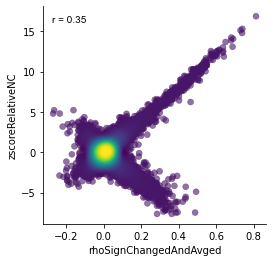

In [44]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=GilbertRicinCleanData, x='rhoSignChangedAndAvged', y='zscoreRelativeNC')
gpplot.add_correlation(data=GilbertRicinCleanData, x='rhoSignChangedAndAvged', y='zscoreRelativeNC')
sns.despine()

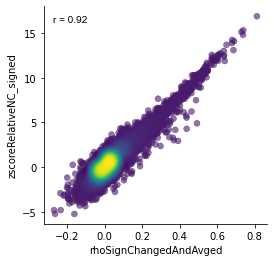

In [45]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=GilbertRicinCleanData, x='rhoSignChangedAndAvged', y='zscoreRelativeNC_signed')
gpplot.add_correlation(data=GilbertRicinCleanData, x='rhoSignChangedAndAvged', y='zscoreRelativeNC_signed')
sns.despine()
# for only the cleaned guide
# they are not corr of 1 because the same context seqs are aveeraged in respective phenotype

In [46]:
GilbertRicinCleanData.to_csv('../Data/CleanedExternalData/Gilbert2014Cleaned2024_v1.csv',
                    index = False)